In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
languages = [
    'Spanish',
    'English',
    'German',
    'French'
]

file_directory = os.getcwd()
extractedFeatures_folder = 'ExtractedFeatures/'

df_full = pd.DataFrame()
for language in languages:
    df_language = pd.read_csv(file_directory + '/' + extractedFeatures_folder + '/' + language + '.csv', delimiter=";", encoding='utf-8')
    df_language['Class'] = language
    df_full = pd.concat([df_full, df_language], ignore_index=True)
    df_full = df_full.reindex(range(df_full.shape[0]))

X = df_full.drop(['phrase', 'Class'], axis=1)
y = df_full['Class']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [4]:
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

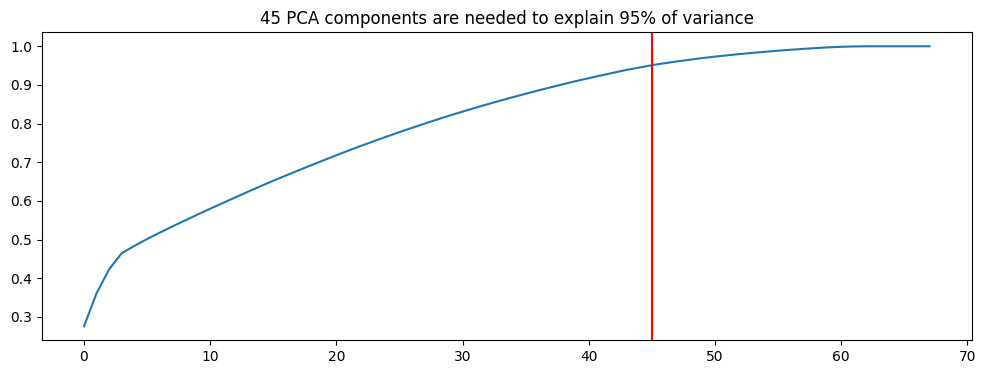

In [5]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=x_test.shape[1])
pca_full.fit(x_train_scaled)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

In [6]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(x_train_scaled)

In [7]:
knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
knn_raw.fit(x_train_scaled,y_train) # fit the model using training data
y_test_pred_raw = knn_raw.predict(x_test_scaled)

cm_raw = confusion_matrix(y_test, y_test_pred_raw)

              precision    recall  f1-score   support

     Spanish       0.95      1.00      0.97      6757
     English       0.89      0.94      0.91       789
      German       0.99      0.90      0.94      3527
      French       0.98      0.94      0.96      1319

    accuracy                           0.96     12392
   macro avg       0.95      0.94      0.95     12392
weighted avg       0.96      0.96      0.96     12392



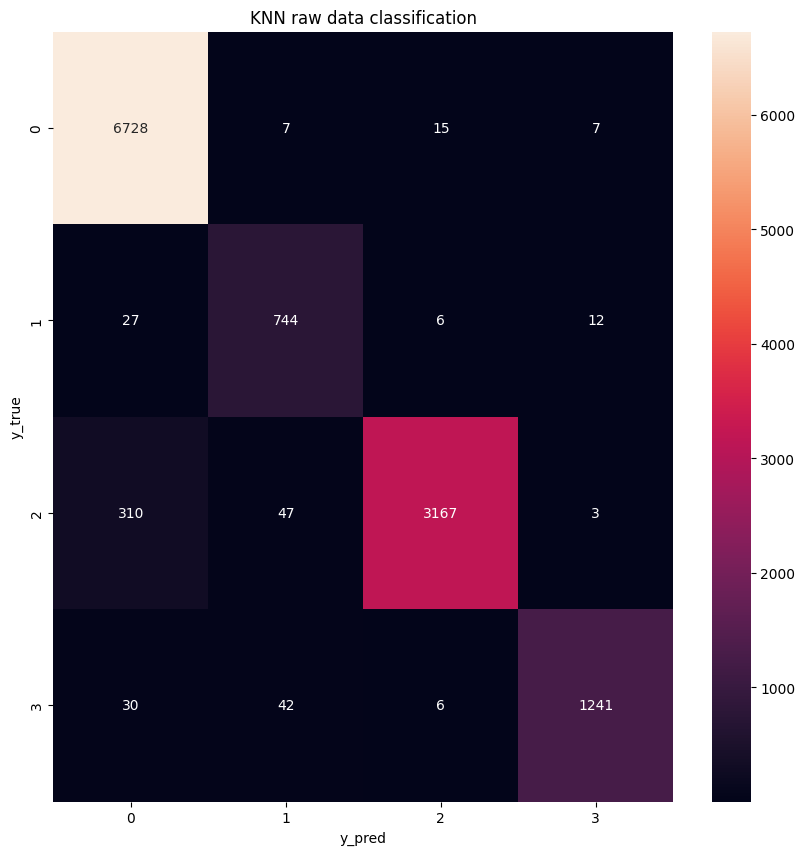

In [8]:
fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN raw data classification')

label_names = ['Spanish','English','German','French']
print(classification_report(y_test, y_test_pred_raw, target_names=label_names))